In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import os
from PIL import Image

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.set_default_device(device)

In [3]:
def crop_n_reshape(paths, target_size):
    imgs = Image.open(paths)
    width, height = imgs.size
    longer_size, shorter_size = max(height, width), min(height, width)
    crop_margin = (longer_size - shorter_size) // 2
    
    if height >= width:
        cropped = imgs.crop((0, crop_margin, shorter_size, crop_margin + shorter_size))
    else:
        cropped = imgs.crop((crop_margin, 0, crop_margin + shorter_size, shorter_size))
        
    resized = cropped.resize(target_size, Image.BILINEAR)
    return transforms.ToTensor()(resized)

(0.0, 1.0, 0.0, 1.0)

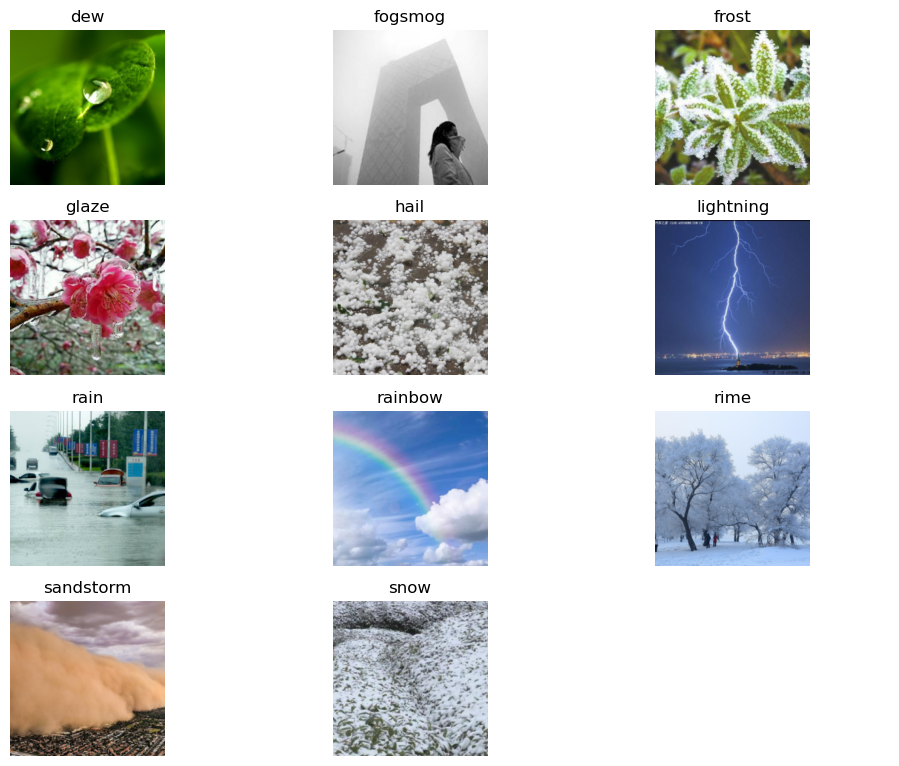

In [4]:
data_dir = "data/weather/dataset"
fig, axes = plt.subplots(4, 3, figsize = (10, 8))
ax = axes.flatten()
num_weather = {}

for i, file in enumerate(os.listdir(data_dir)):
    files = os.path.join(data_dir, file)
    total_imgs = os.listdir(files)
    num_weather[file] = len(total_imgs)
    images = os.path.join(files, total_imgs[0])
    
    
    ax[i].imshow(crop_n_reshape(images, (256, 256)).movedim(0, -1))
    ax[i].set_title(f"{file}")
    ax[i].axis("off")
    
plt.tight_layout()
plt.axis("off")


<BarContainer object of 11 artists>

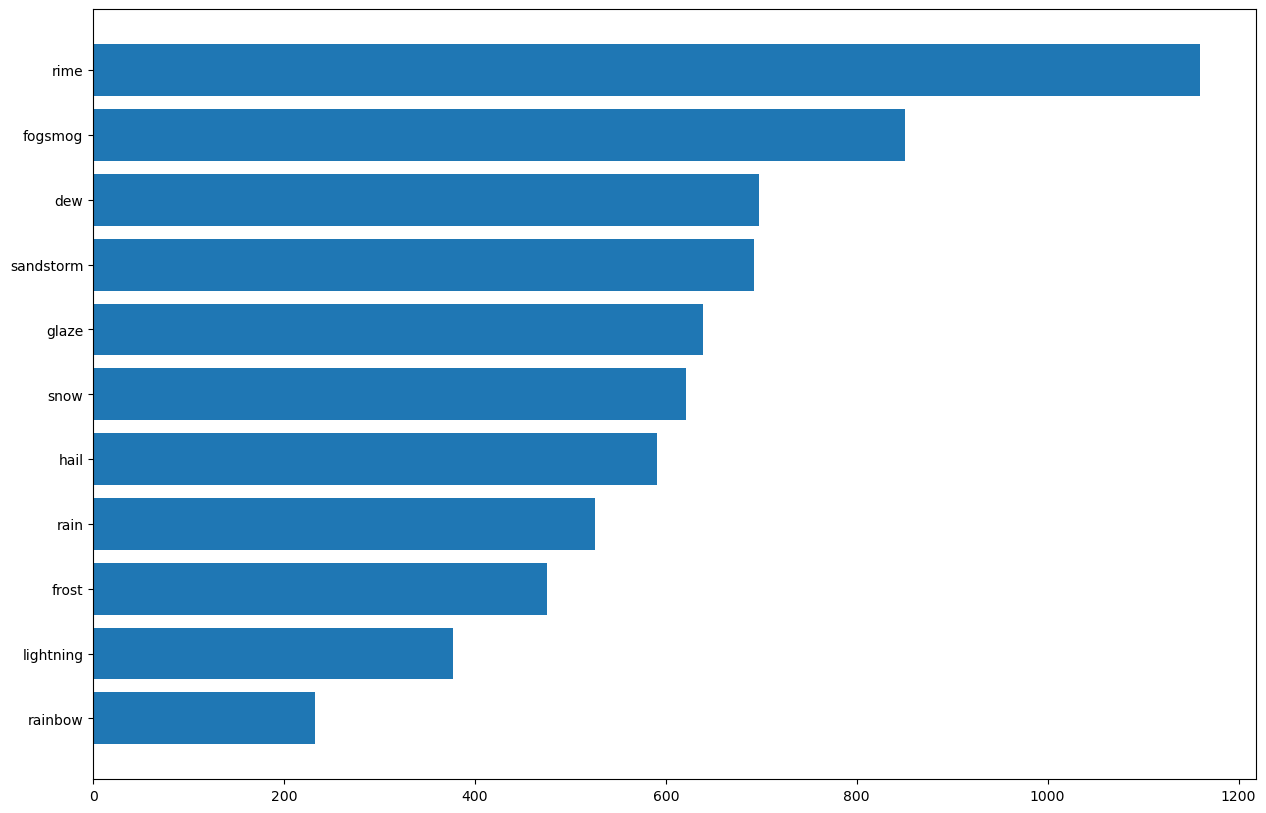

In [5]:
weather_sorted = {k: v for k, v in sorted(num_weather.items(), key = lambda item: item[1])}
plt.figure(figsize = (15, 10))
plt.barh(list(weather_sorted.keys()), weather_sorted.values())

In [6]:
class CropNReshape(object):
    def __init__(self, size):
        self.size = size
        
    def __call__(self, imgs):
        width, height = imgs.size
        longer_size, shorter_size = max(height, width), min(height, width)
        crop_margin = (longer_size - shorter_size) // 2
    
        if height >= width:
            cropped = imgs.crop((0, crop_margin, shorter_size, crop_margin + shorter_size))
        else:
            cropped = imgs.crop((crop_margin, 0, crop_margin + shorter_size, shorter_size))
        
        resized = cropped.resize(self.size, Image.BILINEAR)
        return resized

In [7]:
from torch.utils.data import Dataset, DataLoader, Subset

class WeatherDataset(Dataset):
    def __init__(self, root_dir, transform = None, target_transform = None):
        self.transform = transform
        self.paths = []
        for i, (path, names, filenames) in enumerate(os.walk(root_dir)):
            if filenames:
                self.paths.append([(os.path.join(path, image), i - 1) for image in filenames])
        self.paths = np.concatenate(self.paths, axis = 0)
        self.labels = self.paths[:, 1]
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):  
        image_filepath = self.paths[idx][0]
        image = Image.open(image_filepath).convert("RGB")
        labels = int(self.labels[idx])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)
        
        return image, labels
        

In [8]:
trainset = WeatherDataset(data_dir, transforms.Compose([CropNReshape(size = (256, 256)),
                                                        transforms.ToTensor()]))

In [9]:
from torch.utils.data import ConcatDataset 
x = torch.stack([sample[0] for sample in ConcatDataset([trainset])])

In [10]:
mean = torch.mean(x, dim=(0,2,3)) 
std = torch.std(x, dim=(0,2,3)) 

transform = transforms.Compose([
    CropNReshape((256, 256)),
    transforms.Normalize(mean = mean, std = std),
    transforms.ToTensor()
])


In [11]:
data = DataLoader(WeatherDataset(data_dir, transform = transform),
                  batch_size = 32, shuffle = True)

In [12]:
from sklearn.model_selection import train_test_split

train_indices_full, test_indices, _, _ = train_test_split(
    range(len(trainset)),
    trainset.labels,
    stratify=trainset.labels,
    test_size=0.1,
    random_state=42
)

test_split = Subset(trainset, test_indices)

In [13]:
train_indices, valid_indices, _, _ = train_test_split(
    range(len(train_indices_full)),
    trainset.labels[train_indices_full],
    stratify=trainset.labels[train_indices_full],
    test_size=0.1,
    random_state=42
)

train_split, valid_split = Subset(trainset, train_indices), Subset(trainset, valid_indices)


In [14]:
batch_size = 200

train_batches = DataLoader(train_split, batch_size = batch_size, shuffle = True, 
                           generator = torch.Generator(device = "cuda"))
valid_batches = DataLoader(valid_split, batch_size = batch_size)
test_batches = DataLoader(test_split, batch_size = batch_size)

In [15]:
model = torchvision.models.resnet18(weights = "IMAGENET1K_V1")
features = model.fc.in_features
model.fc = nn.Linear(features, 11)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr = 1e-3)

def train(dataloader, valid_dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(x)
            print(f"loss: {loss:>5f}  [{current:>3d}/{size:>3d}]")
    
    model.eval()
    size = len(valid_dataloader.dataset)
    num_batches = len(valid_dataloader)
    valid_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in valid_dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            valid_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    valid_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {valid_loss:>8f} \n")
            
    
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    #can swap this loss out with /= size and multiply test_loss by x.size(0)
    #loss function calculates mean loss by default according to the batch size
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [16]:
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_batches, valid_batches, model, loss_fn, optimizer)

Epoch 1
-------------------------------
loss: 2.445203  [200/5557]
Test Error: 
 Accuracy: 48.2%, Avg loss: 2.611011 

Epoch 2
-------------------------------
loss: 0.233811  [200/5557]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.691515 

Epoch 3
-------------------------------
loss: 0.090833  [200/5557]
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.418914 

Epoch 4
-------------------------------
loss: 0.121877  [200/5557]
Test Error: 
 Accuracy: 83.5%, Avg loss: 0.631215 

Epoch 5
-------------------------------
loss: 0.068313  [200/5557]
Test Error: 
 Accuracy: 85.6%, Avg loss: 0.396264 



In [19]:
test(test_batches, model, loss_fn)

Test Error: 
 Accuracy: 85.7%, Avg loss: 0.890304 



In [ ]:
#testing purposes
#paths = []
#for i, (path, names, filenames) in enumerate(os.walk(data_dir)):
#    if filenames:
#        paths.append([(os.path.join(path, image), int(i - 1)) for image in filenames])
#paths = np.concatenate(paths, axis = 0)